In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

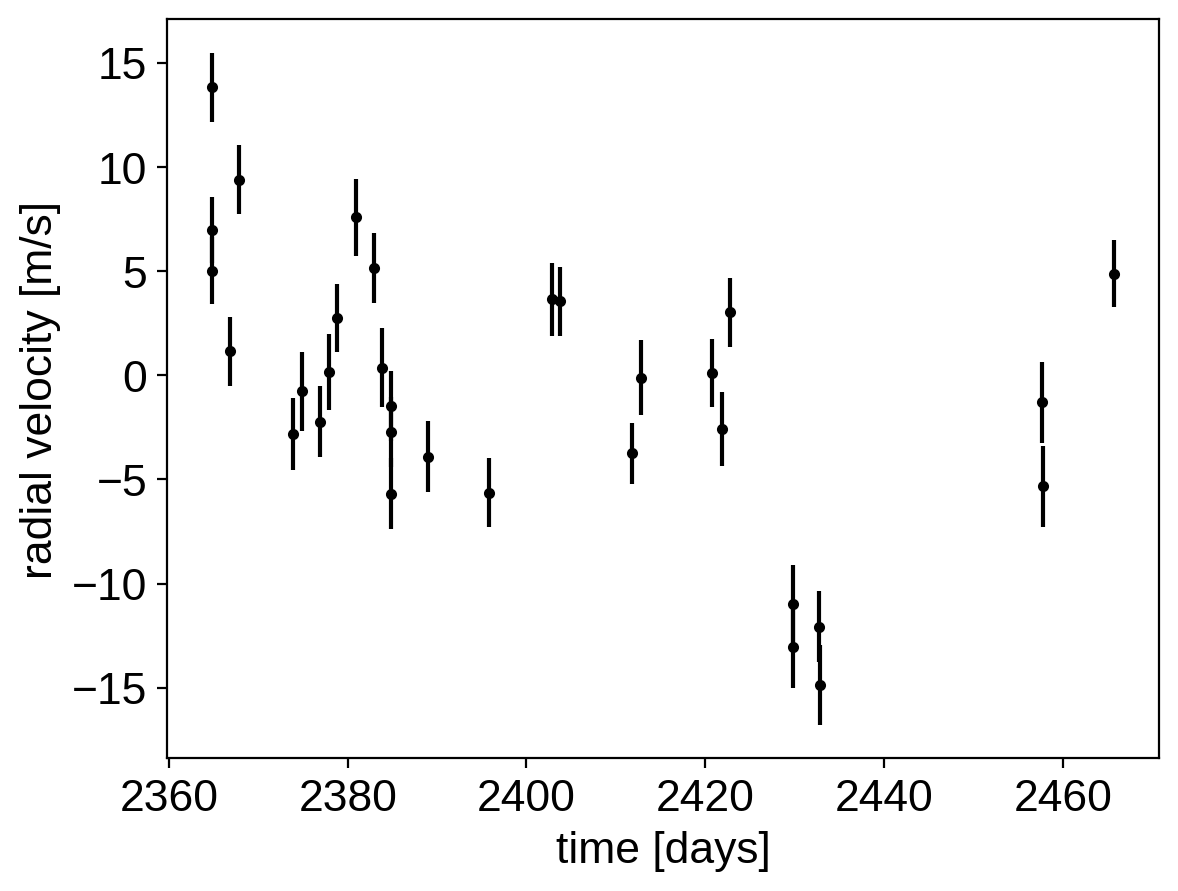

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=2, testval=np.array([0.1, 0.1])
    )
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


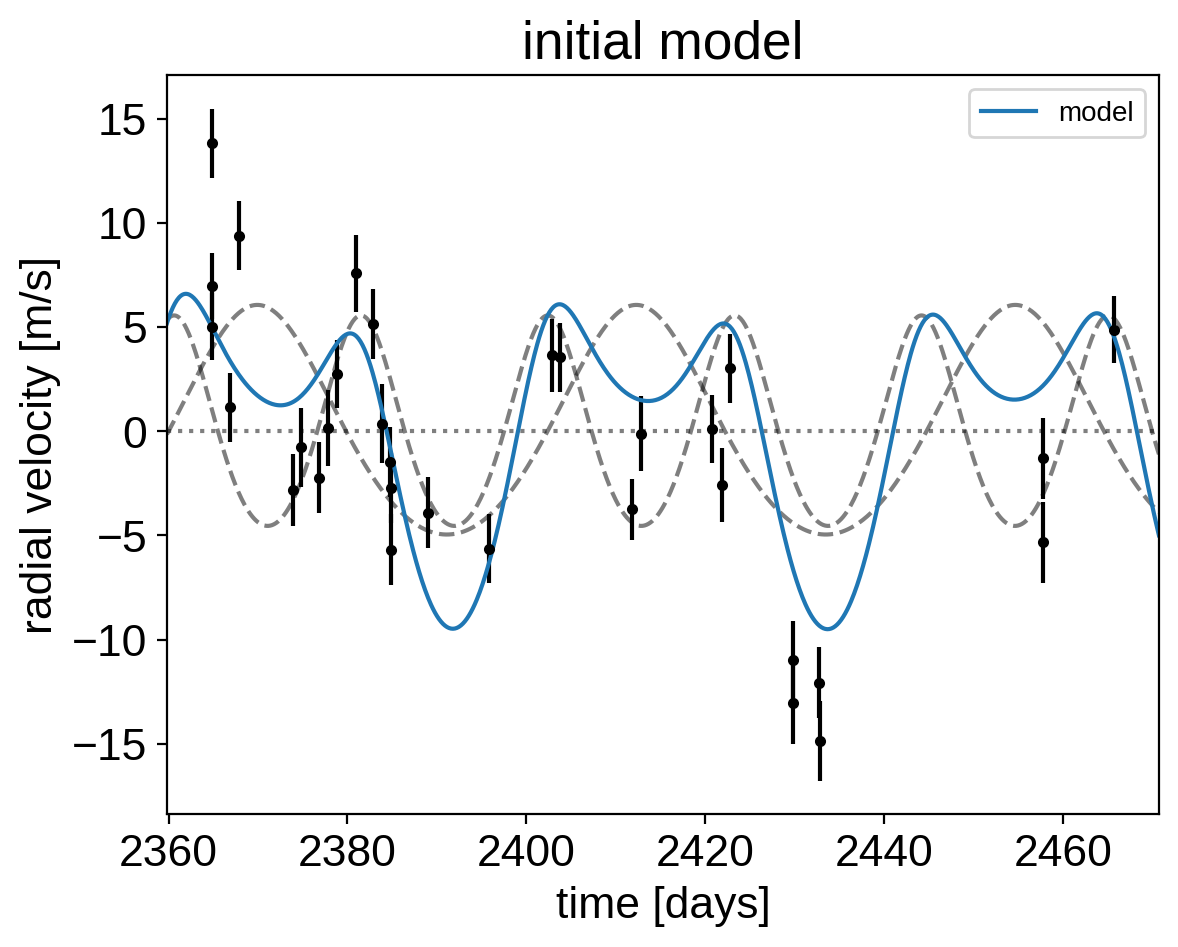

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.

In [7]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 667.14it/s, logp=-7.973266e+01]

2it [00:00, 763.92it/s, logp=-5.305392e+06]

3it [00:00, 848.71it/s, logp=-7.966783e+01]

4it [00:00, 820.92it/s, logp=-7.953812e+01]

5it [00:00, 893.39it/s, logp=-7.904438e+01]

6it [00:00, 956.29it/s, logp=-7.747076e+01]

7it [00:00, 957.20it/s, logp=-7.344108e+01]

8it [00:00, 965.71it/s, logp=-6.722892e+01]

9it [00:00, 930.25it/s, logp=-6.484820e+01]

10it [00:00, 923.49it/s, logp=-6.484820e+01]

11it [00:00, 927.76it/s, logp=-6.484820e+01]

12it [00:00, 13.19it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 617.54it/s, logp=-6.484820e+01]

2it [00:00, 702.03it/s, logp=-4.990134e+09]

3it [00:00, 788.75it/s, logp=-6.484832e+01]

4it [00:00, 812.85it/s, logp=-6.484777e+01]

5it [00:00, 808.46it/s, logp=-6.519268e+01]

6it [00:00, 837.99it/s, logp=-6.484777e+01]

7it [00:00, 824.70it/s, logp=-6.484777e+01]

8it [00:00, 850.08it/s, logp=-6.484776e+01]

9it [00:00, 867.85it/s, logp=-6.484774e+01]

10it [00:00, 886.07it/s, logp=-6.484767e+01]

11it [00:00, 892.99it/s, logp=-6.484739e+01]

12it [00:00, 911.36it/s, logp=-6.484633e+01]

13it [00:00, 914.08it/s, logp=-6.484353e+01]

14it [00:00, 928.37it/s, logp=-6.483426e+01]

15it [00:00, 897.95it/s, logp=-6.481055e+01]

16it [00:00, 908.18it/s, logp=-6.472940e+01]

17it [00:00, 899.77it/s, logp=-6.451928e+01]

18it [00:00, 910.95it/s, logp=-6.371170e+01]

19it [00:00, 919.02it/s, logp=-6.096678e+01]

20it [00:00, 902.49it/s, logp=-5.708652e+01]

21it [00:00, 895.91it/s, logp=-5.027536e+01]

22it [00:00, 894.97it/s, logp=-2.386568e+02]

23it [00:00, 896.92it/s, logp=-4.912172e+01]

24it [00:00, 898.44it/s, logp=-4.707357e+01]

25it [00:00, 896.39it/s, logp=-4.319328e+01]

26it [00:00, 898.81it/s, logp=-3.608487e+01]

27it [00:00, 900.39it/s, logp=-2.498567e+01]

28it [00:00, 893.86it/s, logp=-2.442071e+01]

29it [00:00, 897.24it/s, logp=-2.333036e+01]

30it [00:00, 902.68it/s, logp=-2.011091e+01]

31it [00:00, 905.26it/s, logp=-1.751350e+01]

32it [00:00, 907.43it/s, logp=-1.714559e+01]

33it [00:00, 906.53it/s, logp=-1.693796e+01]

34it [00:00, 885.34it/s, logp=-1.684943e+01]

35it [00:00, 870.84it/s, logp=-1.676095e+01]

36it [00:00, 864.97it/s, logp=-1.673569e+01]

37it [00:00, 855.72it/s, logp=-1.672214e+01]

38it [00:00, 858.14it/s, logp=-1.670758e+01]

39it [00:00, 849.10it/s, logp=-1.668064e+01]

40it [00:00, 849.47it/s, logp=-1.662858e+01]

41it [00:00, 853.20it/s, logp=-1.658058e+01]

42it [00:00, 857.41it/s, logp=-1.655728e+01]

43it [00:00, 857.28it/s, logp=-1.662929e+01]

44it [00:00, 861.35it/s, logp=-1.647872e+01]

45it [00:00, 862.60it/s, logp=-1.635178e+01]

46it [00:00, 862.33it/s, logp=-1.613280e+01]

47it [00:00, 861.67it/s, logp=-1.577352e+01]

48it [00:00, 855.09it/s, logp=-1.525205e+01]

49it [00:00, 856.39it/s, logp=-1.849895e+01]

50it [00:00, 860.17it/s, logp=-1.514689e+01]

51it [00:00, 859.24it/s, logp=-1.501721e+01]

52it [00:00, 851.83it/s, logp=-1.496658e+01]

53it [00:00, 851.91it/s, logp=-1.495457e+01]

54it [00:00, 852.46it/s, logp=-1.494704e+01]

55it [00:00, 852.34it/s, logp=-1.494509e+01]

56it [00:00, 852.56it/s, logp=-1.494181e+01]

57it [00:00, 849.51it/s, logp=-1.493619e+01]

58it [00:00, 849.05it/s, logp=-1.492655e+01]

59it [00:00, 847.33it/s, logp=-1.491151e+01]

60it [00:00, 847.97it/s, logp=-1.489345e+01]

61it [00:00, 847.35it/s, logp=-1.486580e+01]

62it [00:00, 847.83it/s, logp=-1.483881e+01]

63it [00:00, 847.98it/s, logp=-1.479783e+01]

64it [00:00, 849.64it/s, logp=-1.475797e+01]

65it [00:00, 847.78it/s, logp=-1.470224e+01]

66it [00:00, 846.99it/s, logp=-1.466581e+01]

67it [00:00, 849.43it/s, logp=-1.465792e+01]

68it [00:00, 848.00it/s, logp=-1.460984e+01]

69it [00:00, 848.58it/s, logp=-1.453216e+01]

70it [00:00, 848.14it/s, logp=-1.441150e+01]

71it [00:00, 848.60it/s, logp=-1.431230e+01]

72it [00:00, 848.64it/s, logp=-1.436794e+01]

73it [00:00, 847.29it/s, logp=-1.429690e+01]

74it [00:00, 847.64it/s, logp=-1.428194e+01]

75it [00:00, 848.82it/s, logp=-1.427769e+01]

76it [00:00, 849.50it/s, logp=-1.427703e+01]

77it [00:00, 849.98it/s, logp=-1.427688e+01]

78it [00:00, 850.73it/s, logp=-1.427678e+01]

79it [00:00, 845.33it/s, logp=-1.427677e+01]

80it [00:00, 845.04it/s, logp=-1.427676e+01]

81it [00:00, 845.67it/s, logp=-1.427676e+01]

82it [00:00, 843.96it/s, logp=-1.427676e+01]

83it [00:00, 843.04it/s, logp=-1.427676e+01]

84it [00:00, 842.71it/s, logp=-1.427676e+01]

85it [00:00, 847.78it/s, logp=-1.427676e+01]

85it [00:00, 847.78it/s, logp=-1.427676e+01]

86it [00:00, 847.78it/s, logp=-1.427676e+01]

87it [00:00, 847.78it/s, logp=-1.427676e+01]

88it [00:00, 847.78it/s, logp=-1.427676e+01]

89it [00:00, 847.78it/s, logp=-1.427676e+01]

90it [00:00, 847.78it/s, logp=-1.427676e+01]

91it [00:00, 847.78it/s, logp=-1.427676e+01]

92it [00:00, 847.78it/s, logp=-1.427676e+01]

93it [00:00, 199.53it/s, logp=-1.427676e+01]


message: Optimization terminated successfully.
logp: -64.8482026233154 -> -14.276760262380932


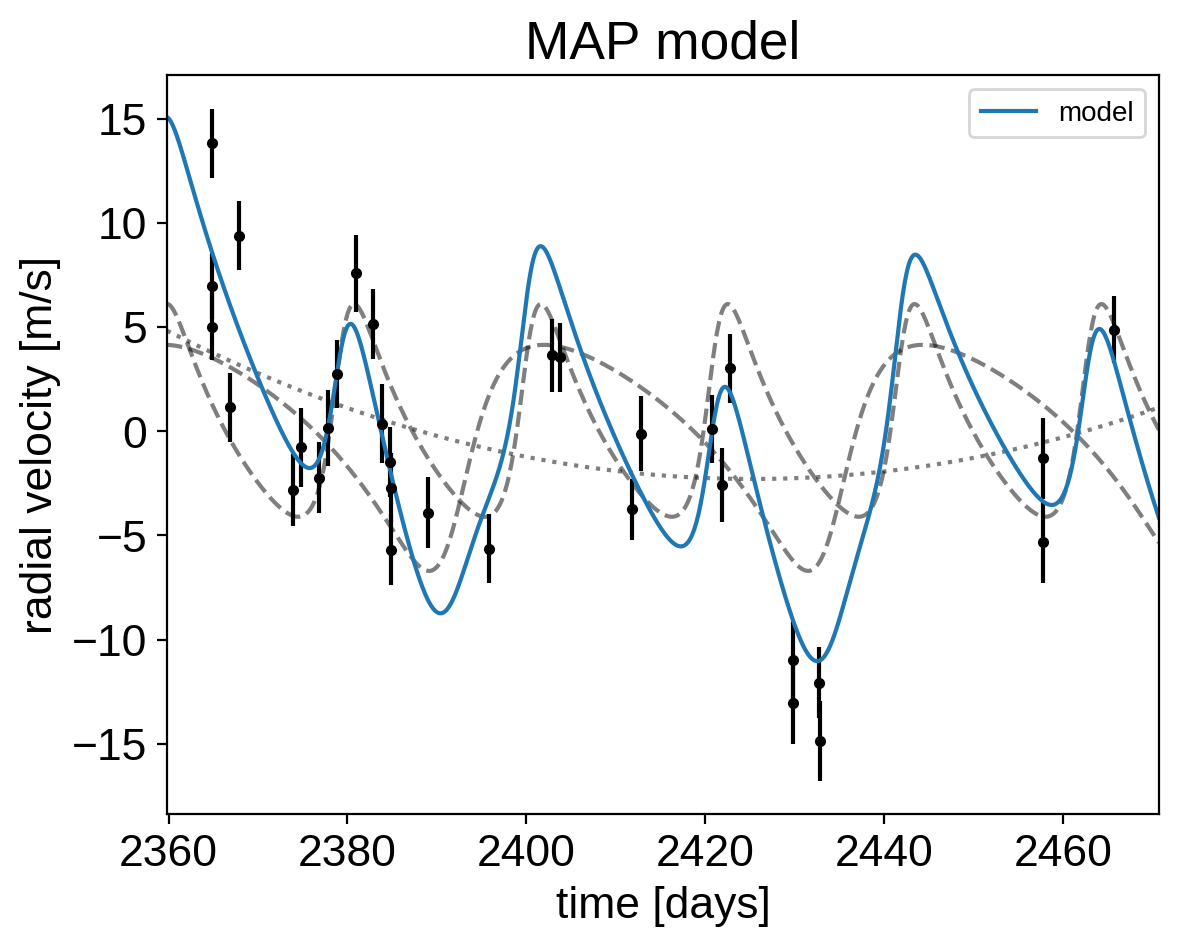

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [9]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/16000 [00:00<03:51, 69.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/16000 [00:00<05:36, 47.56draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/16000 [00:00<06:52, 38.76draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/16000 [00:00<07:46, 34.28draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/16000 [00:00<08:21, 31.85draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/16000 [00:00<08:48, 30.19draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/16000 [00:01<09:05, 29.27draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 39/16000 [00:01<09:21, 28.45draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 43/16000 [00:01<09:28, 28.05draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 47/16000 [00:01<09:27, 28.09draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/16000 [00:01<09:28, 28.05draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/16000 [00:01<09:24, 28.24draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/16000 [00:01<09:22, 28.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/16000 [00:01<09:25, 28.17draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/16000 [00:02<09:36, 27.66draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 67/16000 [00:02<09:23, 28.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 70/16000 [00:02<09:45, 27.22draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 74/16000 [00:02<09:43, 27.31draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 78/16000 [00:02<09:47, 27.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 82/16000 [00:02<09:50, 26.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 86/16000 [00:02<09:42, 27.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/16000 [00:03<09:38, 27.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/16000 [00:03<09:32, 27.77draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/16000 [00:03<09:29, 27.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/16000 [00:03<09:25, 28.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 105/16000 [00:03<09:16, 28.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/16000 [00:03<10:02, 26.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/16000 [00:03<09:50, 26.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/16000 [00:03<09:40, 27.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/16000 [00:04<09:29, 27.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/16000 [00:04<09:44, 27.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/16000 [00:04<09:43, 27.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/16000 [00:04<09:31, 27.76draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/16000 [00:04<09:45, 27.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 135/16000 [00:04<09:53, 26.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 139/16000 [00:04<09:50, 26.84draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/16000 [00:04<09:46, 27.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 147/16000 [00:05<09:45, 27.06draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/16000 [00:05<09:47, 26.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 155/16000 [00:05<09:43, 27.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 159/16000 [00:05<09:36, 27.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/16000 [00:05<09:35, 27.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 167/16000 [00:05<09:32, 27.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/16000 [00:05<09:27, 27.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/16000 [00:06<09:26, 27.95draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/16000 [00:06<09:26, 27.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 183/16000 [00:06<09:23, 28.05draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 186/16000 [00:06<09:25, 27.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 189/16000 [00:06<10:35, 24.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 193/16000 [00:06<09:37, 27.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 196/16000 [00:06<09:54, 26.57draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 200/16000 [00:07<09:44, 27.05draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 203/16000 [00:07<09:35, 27.45draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 206/16000 [00:07<09:34, 27.47draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 209/16000 [00:07<09:52, 26.66draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 213/16000 [00:07<09:53, 26.59draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 217/16000 [00:07<09:50, 26.71draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 221/16000 [00:07<09:42, 27.09draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 225/16000 [00:07<09:38, 27.27draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 229/16000 [00:08<09:32, 27.55draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 232/16000 [00:08<09:22, 28.01draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 235/16000 [00:08<09:36, 27.35draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 239/16000 [00:08<09:31, 27.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 242/16000 [00:08<09:18, 28.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 245/16000 [00:08<09:54, 26.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/16000 [00:08<09:48, 26.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/16000 [00:08<09:43, 26.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 257/16000 [00:09<09:41, 27.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 261/16000 [00:09<09:44, 26.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 265/16000 [00:09<09:45, 26.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 269/16000 [00:09<09:41, 27.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/16000 [00:09<09:46, 26.83draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/16000 [00:09<09:44, 26.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/16000 [00:10<09:43, 26.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/16000 [00:10<09:36, 27.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 289/16000 [00:10<09:48, 26.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/16000 [00:10<09:43, 26.92draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/16000 [00:10<09:33, 27.36draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 301/16000 [00:10<09:30, 27.53draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 305/16000 [00:10<09:34, 27.32draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 309/16000 [00:11<09:29, 27.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 313/16000 [00:11<09:25, 27.76draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 316/16000 [00:11<09:15, 28.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 319/16000 [00:11<09:22, 27.90draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 322/16000 [00:11<09:30, 27.47draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 326/16000 [00:11<09:35, 27.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 330/16000 [00:11<09:35, 27.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 334/16000 [00:11<09:41, 26.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 338/16000 [00:12<09:38, 27.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 342/16000 [00:12<09:41, 26.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 346/16000 [00:12<09:34, 27.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 350/16000 [00:12<08:57, 29.14draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 354/16000 [00:12<09:10, 28.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 357/16000 [00:12<09:35, 27.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 360/16000 [00:12<09:23, 27.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 363/16000 [00:13<09:28, 27.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 366/16000 [00:13<09:32, 27.31draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 369/16000 [00:13<09:18, 28.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 372/16000 [00:13<09:45, 26.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 376/16000 [00:13<09:32, 27.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 380/16000 [00:13<09:25, 27.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 384/16000 [00:13<09:20, 27.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 388/16000 [00:13<08:48, 29.54draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 392/16000 [00:13<08:12, 31.72draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 396/16000 [00:14<07:58, 32.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 400/16000 [00:14<07:42, 33.71draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 405/16000 [00:14<07:12, 36.09draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 409/16000 [00:14<09:50, 26.40draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 413/16000 [00:14<10:10, 25.53draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 417/16000 [00:14<09:22, 27.69draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 421/16000 [00:15<12:38, 20.55draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 428/16000 [00:15<10:04, 25.75draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 436/16000 [00:15<08:02, 32.27draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 443/16000 [00:15<06:50, 37.87draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 450/16000 [00:15<05:54, 43.85draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 459/16000 [00:15<05:05, 50.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 472/16000 [00:15<04:10, 61.89draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 481/16000 [00:15<03:51, 66.98draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 490/16000 [00:16<03:35, 71.88draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 500/16000 [00:16<03:22, 76.48draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 512/16000 [00:16<03:06, 82.95draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 524/16000 [00:16<02:55, 88.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 538/16000 [00:16<02:38, 97.74draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 552/16000 [00:16<02:25, 106.37draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 570/16000 [00:16<02:07, 121.05draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 589/16000 [00:16<01:54, 134.97draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 605/16000 [00:16<01:49, 140.51draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 621/16000 [00:17<01:51, 137.70draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 637/16000 [00:17<01:47, 142.61draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 654/16000 [00:17<01:44, 147.27draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 672/16000 [00:17<01:39, 154.76draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 690/16000 [00:17<01:35, 159.57draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 709/16000 [00:17<01:32, 164.94draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 726/16000 [00:17<01:32, 164.25draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 744/16000 [00:17<01:31, 166.33draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 761/16000 [00:17<01:34, 161.87draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 778/16000 [00:17<01:33, 162.89draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 795/16000 [00:18<01:32, 164.87draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 815/16000 [00:18<01:28, 171.75draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 834/16000 [00:18<01:26, 176.03draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 852/16000 [00:18<01:32, 164.47draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 869/16000 [00:18<01:32, 164.05draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 888/16000 [00:18<01:29, 168.46draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 905/16000 [00:18<01:37, 154.65draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 921/16000 [00:18<01:47, 139.94draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 936/16000 [00:18<01:47, 140.15draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 951/16000 [00:19<01:54, 131.30draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 965/16000 [00:19<01:57, 127.50draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 980/16000 [00:19<01:54, 131.34draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 994/16000 [00:19<01:52, 133.80draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1013/16000 [00:19<01:42, 145.58draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1034/16000 [00:19<01:34, 158.66draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1055/16000 [00:19<01:28, 169.12draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1075/16000 [00:19<01:24, 175.75draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1097/16000 [00:19<01:20, 185.91draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1117/16000 [00:20<01:20, 185.26draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1136/16000 [00:20<01:21, 182.49draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1158/16000 [00:20<01:17, 191.34draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1178/16000 [00:20<01:16, 192.60draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1200/16000 [00:20<01:15, 197.10draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1222/16000 [00:20<01:14, 198.85draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1244/16000 [00:20<01:12, 203.96draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1265/16000 [00:20<01:12, 203.96draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1286/16000 [00:20<01:18, 186.77draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1306/16000 [00:21<01:47, 136.86draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1322/16000 [00:21<01:59, 122.76draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1337/16000 [00:21<02:04, 117.40draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1351/16000 [00:21<02:00, 121.37draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1368/16000 [00:21<01:50, 132.48draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1386/16000 [00:21<01:42, 143.01draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1402/16000 [00:21<01:44, 140.07draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1417/16000 [00:22<02:17, 105.84draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1430/16000 [00:22<02:44, 88.57draws/s] 

Sampling 2 chains, 0 divergences:   9%|▉         | 1441/16000 [00:22<02:43, 88.96draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1452/16000 [00:22<02:46, 87.41draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1463/16000 [00:22<02:40, 90.72draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1476/16000 [00:22<02:28, 97.82draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1490/16000 [00:22<02:17, 105.36draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1502/16000 [00:23<02:22, 102.07draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1513/16000 [00:23<02:28, 97.24draws/s] 

Sampling 2 chains, 0 divergences:  10%|▉         | 1524/16000 [00:23<02:25, 99.42draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1537/16000 [00:23<02:18, 104.31draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1549/16000 [00:23<02:13, 108.07draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1562/16000 [00:23<02:08, 112.57draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1576/16000 [00:23<02:00, 119.53draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1591/16000 [00:23<01:54, 126.19draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1606/16000 [00:23<01:51, 129.11draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1624/16000 [00:23<01:42, 140.84draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1643/16000 [00:24<01:34, 152.09draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1659/16000 [00:24<01:35, 150.68draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1675/16000 [00:24<01:39, 143.32draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1692/16000 [00:24<01:36, 148.88draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1710/16000 [00:24<01:32, 154.77draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1729/16000 [00:24<01:28, 162.05draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1746/16000 [00:24<01:29, 160.11draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1763/16000 [00:24<01:32, 153.40draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1779/16000 [00:24<01:32, 153.75draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1798/16000 [00:25<01:27, 162.79draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1815/16000 [00:25<01:29, 158.40draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1835/16000 [00:25<01:24, 168.42draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1853/16000 [00:25<01:22, 170.59draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1871/16000 [00:25<01:22, 171.28draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1891/16000 [00:25<01:18, 178.89draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1911/16000 [00:25<01:18, 179.56draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1932/16000 [00:25<01:15, 186.13draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1951/16000 [00:25<01:15, 185.59draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1971/16000 [00:26<01:14, 187.96draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1993/16000 [00:26<01:11, 195.11draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2015/16000 [00:26<01:10, 199.42draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2036/16000 [00:26<01:11, 194.68draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2056/16000 [00:26<01:12, 193.34draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2076/16000 [00:26<01:18, 178.37draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2095/16000 [00:26<01:20, 173.63draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2113/16000 [00:26<01:23, 166.47draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2130/16000 [00:26<01:28, 156.42draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2146/16000 [00:27<01:28, 156.37draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2162/16000 [00:27<01:30, 153.64draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2178/16000 [00:27<01:29, 153.72draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2194/16000 [00:27<01:35, 145.29draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2213/16000 [00:27<01:28, 156.05draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2230/16000 [00:27<01:26, 159.23draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2249/16000 [00:27<01:22, 167.02draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2269/16000 [00:27<01:19, 172.85draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2287/16000 [00:27<01:19, 172.21draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2305/16000 [00:27<01:19, 171.48draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2323/16000 [00:28<01:22, 165.68draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2340/16000 [00:28<01:21, 166.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2357/16000 [00:28<01:25, 158.95draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2374/16000 [00:28<01:29, 151.97draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2391/16000 [00:28<01:27, 155.62draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2408/16000 [00:28<01:26, 157.55draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2424/16000 [00:28<01:27, 155.88draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2440/16000 [00:28<01:27, 154.55draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2456/16000 [00:28<01:29, 151.07draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2472/16000 [00:29<01:40, 134.32draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2486/16000 [00:29<01:43, 130.64draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2504/16000 [00:29<01:36, 139.27draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2519/16000 [00:29<01:35, 140.85draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2537/16000 [00:29<01:29, 149.72draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2557/16000 [00:29<01:23, 160.95draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2576/16000 [00:29<01:20, 167.28draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2594/16000 [00:29<01:18, 169.80draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2612/16000 [00:29<01:22, 163.19draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2629/16000 [00:30<01:26, 155.17draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2645/16000 [00:30<01:29, 149.72draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2661/16000 [00:30<01:28, 151.18draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2678/16000 [00:30<01:25, 156.17draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2694/16000 [00:30<01:26, 153.08draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2710/16000 [00:30<01:27, 151.48draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2726/16000 [00:30<01:27, 151.65draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2742/16000 [00:30<01:27, 150.68draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2759/16000 [00:30<01:26, 153.05draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2775/16000 [00:31<01:29, 148.05draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2793/16000 [00:31<01:25, 154.59draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2812/16000 [00:31<01:20, 163.21draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2831/16000 [00:31<01:18, 167.60draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2851/16000 [00:31<01:14, 175.48draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2869/16000 [00:31<01:14, 175.85draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2887/16000 [00:31<01:14, 175.72draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2905/16000 [00:31<01:16, 170.43draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2924/16000 [00:31<01:14, 175.60draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2943/16000 [00:32<01:13, 177.80draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2961/16000 [00:32<01:14, 175.00draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2979/16000 [00:32<01:13, 176.17draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2997/16000 [00:32<01:18, 164.80draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3014/16000 [00:32<01:24, 153.81draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3030/16000 [00:32<01:26, 150.36draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3047/16000 [00:32<01:23, 154.54draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3066/16000 [00:32<01:19, 163.22draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3087/16000 [00:32<01:14, 172.32draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3106/16000 [00:32<01:13, 175.55draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3126/16000 [00:33<01:11, 180.62draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3147/16000 [00:33<01:09, 185.55draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3166/16000 [00:33<01:10, 181.63draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3185/16000 [00:33<01:10, 181.53draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3204/16000 [00:33<01:10, 180.49draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3223/16000 [00:33<01:16, 167.77draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3241/16000 [00:33<01:20, 159.04draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3259/16000 [00:33<01:18, 162.21draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3276/16000 [00:33<01:18, 162.04draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3293/16000 [00:34<01:22, 154.15draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3309/16000 [00:34<01:25, 148.23draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3324/16000 [00:34<01:26, 146.56draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3340/16000 [00:34<01:26, 147.04draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3357/16000 [00:34<01:24, 149.15draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3375/16000 [00:34<01:20, 156.79draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3391/16000 [00:34<01:20, 156.51draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3409/16000 [00:34<01:18, 161.06draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3426/16000 [00:35<01:27, 144.03draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3441/16000 [00:35<01:35, 132.08draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3456/16000 [00:35<01:32, 135.52draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3472/16000 [00:35<01:29, 139.73draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3489/16000 [00:35<01:24, 147.49draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3508/16000 [00:35<01:19, 157.90draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3525/16000 [00:35<01:21, 153.84draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3541/16000 [00:35<01:21, 153.68draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3557/16000 [00:35<01:22, 151.02draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3574/16000 [00:35<01:19, 155.46draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3594/16000 [00:36<01:15, 164.37draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3612/16000 [00:36<01:14, 167.35draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3629/16000 [00:36<01:17, 159.77draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3646/16000 [00:36<01:18, 156.72draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3663/16000 [00:36<01:17, 159.84draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3680/16000 [00:36<01:19, 154.36draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3700/16000 [00:36<01:14, 165.18draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3717/16000 [00:36<01:14, 164.28draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3734/16000 [00:36<01:14, 165.64draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3751/16000 [00:37<01:13, 165.73draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3768/16000 [00:37<01:17, 157.05draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3785/16000 [00:37<01:16, 160.47draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3804/16000 [00:37<01:12, 167.44draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3824/16000 [00:37<01:10, 173.94draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3842/16000 [00:37<01:11, 170.20draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3862/16000 [00:37<01:09, 175.09draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3882/16000 [00:37<01:06, 180.93draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3901/16000 [00:37<01:09, 174.07draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3919/16000 [00:38<01:14, 162.32draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3938/16000 [00:38<01:11, 167.94draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3957/16000 [00:38<01:10, 170.93draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3976/16000 [00:38<01:08, 175.33draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3994/16000 [00:38<01:13, 164.31draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4012/16000 [00:38<01:12, 164.81draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4031/16000 [00:38<01:10, 169.61draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4049/16000 [00:38<01:11, 166.70draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4066/16000 [00:38<01:14, 159.84draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4085/16000 [00:39<01:12, 164.43draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4104/16000 [00:39<01:10, 169.83draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4123/16000 [00:39<01:09, 171.16draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4143/16000 [00:39<01:07, 175.60draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4164/16000 [00:39<01:04, 182.75draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4184/16000 [00:39<01:03, 186.61draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4205/16000 [00:39<01:01, 191.42draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4225/16000 [00:39<01:02, 187.56draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4246/16000 [00:39<01:02, 189.51draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4266/16000 [00:39<01:01, 191.79draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4287/16000 [00:40<01:00, 195.11draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4307/16000 [00:40<01:12, 160.99draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4325/16000 [00:40<01:20, 145.32draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4341/16000 [00:40<01:22, 141.49draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4356/16000 [00:40<01:28, 130.95draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4370/16000 [00:40<01:33, 124.63draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4383/16000 [00:40<01:41, 114.46draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4396/16000 [00:41<01:38, 117.86draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4410/16000 [00:41<01:34, 123.22draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4423/16000 [00:41<01:35, 121.06draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4436/16000 [00:41<01:39, 116.49draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4448/16000 [00:41<01:40, 115.05draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4463/16000 [00:41<01:34, 121.60draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4480/16000 [00:41<01:27, 132.18draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4496/16000 [00:41<01:23, 138.38draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4511/16000 [00:41<01:21, 141.23draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4526/16000 [00:42<01:20, 143.20draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4541/16000 [00:42<01:20, 142.43draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4557/16000 [00:42<01:18, 146.68draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4572/16000 [00:42<01:18, 146.05draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4587/16000 [00:42<01:19, 143.92draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4602/16000 [00:42<01:18, 144.82draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4617/16000 [00:42<01:21, 139.03draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4631/16000 [00:42<01:23, 136.25draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4645/16000 [00:42<01:25, 132.89draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4661/16000 [00:42<01:22, 137.28draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4675/16000 [00:43<01:22, 137.91draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4691/16000 [00:43<01:19, 142.10draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4707/16000 [00:43<01:18, 143.50draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4723/16000 [00:43<01:17, 145.51draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4741/16000 [00:43<01:14, 152.01draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4760/16000 [00:43<01:09, 160.72draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4777/16000 [00:43<01:11, 156.49draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4793/16000 [00:43<01:14, 149.74draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4810/16000 [00:43<01:12, 153.42draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4829/16000 [00:44<01:09, 161.58draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4848/16000 [00:44<01:06, 168.55draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4866/16000 [00:44<01:06, 167.31draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4885/16000 [00:44<01:04, 173.15draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4904/16000 [00:44<01:02, 177.16draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4922/16000 [00:44<01:02, 177.68draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4941/16000 [00:44<01:01, 180.70draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4960/16000 [00:44<01:01, 179.85draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4979/16000 [00:44<01:01, 179.84draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4999/16000 [00:44<01:00, 182.26draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5019/16000 [00:45<00:58, 186.13draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5038/16000 [00:45<00:58, 186.44draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5058/16000 [00:45<00:58, 188.05draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5077/16000 [00:45<00:58, 187.32draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5096/16000 [00:45<00:58, 187.32draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5116/16000 [00:45<00:57, 189.01draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5136/16000 [00:45<00:56, 191.27draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5156/16000 [00:45<00:56, 192.70draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5176/16000 [00:45<00:58, 186.26draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5196/16000 [00:46<00:57, 189.28draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5215/16000 [00:46<00:57, 188.54draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5234/16000 [00:46<01:00, 178.68draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5253/16000 [00:46<01:00, 178.59draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5271/16000 [00:46<01:00, 177.12draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5290/16000 [00:46<00:59, 179.87draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5309/16000 [00:46<00:58, 182.32draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5328/16000 [00:46<01:00, 177.14draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5346/16000 [00:46<00:59, 177.83draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5364/16000 [00:46<01:03, 168.15draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5381/16000 [00:47<01:04, 165.70draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5398/16000 [00:47<01:03, 166.89draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5416/16000 [00:47<01:03, 166.68draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5436/16000 [00:47<01:00, 175.07draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5454/16000 [00:47<01:01, 170.45draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5472/16000 [00:47<01:02, 167.91draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5490/16000 [00:47<01:02, 167.61draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5508/16000 [00:47<01:01, 170.52draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5527/16000 [00:47<01:00, 173.90draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5547/16000 [00:48<00:57, 180.59draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5567/16000 [00:48<00:56, 184.52draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5586/16000 [00:48<00:56, 183.52draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5605/16000 [00:48<00:57, 180.34draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5624/16000 [00:48<00:58, 176.54draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5644/16000 [00:48<00:57, 180.97draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5663/16000 [00:48<00:56, 183.16draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5682/16000 [00:48<00:56, 183.84draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5701/16000 [00:48<00:55, 184.43draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5720/16000 [00:49<01:00, 170.23draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5738/16000 [00:49<01:02, 164.93draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5755/16000 [00:49<01:08, 149.12draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5772/16000 [00:49<01:07, 152.32draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5788/16000 [00:49<01:06, 154.43draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5806/16000 [00:49<01:04, 158.99draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5826/16000 [00:49<01:01, 166.72draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5848/16000 [00:49<00:57, 177.71draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5867/16000 [00:49<00:57, 177.27draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5887/16000 [00:49<00:56, 180.57draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5906/16000 [00:50<00:58, 173.65draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5924/16000 [00:50<00:59, 169.28draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5942/16000 [00:50<00:58, 171.51draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5960/16000 [00:50<00:59, 168.10draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5978/16000 [00:50<01:00, 166.86draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5996/16000 [00:50<00:58, 170.09draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6016/16000 [00:50<00:57, 173.23draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6035/16000 [00:50<00:56, 177.07draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6055/16000 [00:50<00:55, 179.64draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6076/16000 [00:51<00:53, 184.70draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6095/16000 [00:51<00:53, 185.01draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6115/16000 [00:51<00:52, 188.89draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6134/16000 [00:51<00:53, 185.91draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6153/16000 [00:51<00:53, 185.25draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6172/16000 [00:51<00:53, 185.35draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6191/16000 [00:51<00:53, 183.94draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6210/16000 [00:51<00:54, 180.87draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6229/16000 [00:51<00:54, 178.11draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6247/16000 [00:52<00:57, 169.72draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6265/16000 [00:52<01:01, 157.66draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6282/16000 [00:52<01:05, 147.28draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6298/16000 [00:52<01:06, 146.07draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6313/16000 [00:52<01:11, 135.50draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6328/16000 [00:52<01:09, 138.87draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6343/16000 [00:52<01:08, 140.43draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6358/16000 [00:52<01:08, 139.92draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6373/16000 [00:52<01:10, 136.14draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6388/16000 [00:53<01:09, 138.56draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6402/16000 [00:53<01:12, 131.49draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6416/16000 [00:53<01:17, 123.45draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6429/16000 [00:53<01:20, 118.62draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6442/16000 [00:53<01:18, 121.56draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6457/16000 [00:53<01:15, 126.75draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6473/16000 [00:53<01:12, 130.75draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6487/16000 [00:53<01:15, 125.51draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6500/16000 [00:53<01:15, 125.18draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6514/16000 [00:54<01:14, 128.15draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6530/16000 [00:54<01:10, 134.54draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6545/16000 [00:54<01:08, 138.46draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6562/16000 [00:54<01:04, 145.79draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6580/16000 [00:54<01:01, 154.33draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6596/16000 [00:54<01:04, 145.90draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6611/16000 [00:54<01:06, 141.90draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6626/16000 [00:54<01:05, 144.00draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6641/16000 [00:55<01:15, 123.45draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6654/16000 [00:55<01:18, 118.49draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6667/16000 [00:55<01:28, 105.22draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6679/16000 [00:55<01:31, 102.10draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6690/16000 [00:55<01:34, 98.86draws/s] 

Sampling 2 chains, 0 divergences:  42%|████▏     | 6701/16000 [00:55<01:40, 92.81draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6714/16000 [00:55<01:35, 97.57draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6727/16000 [00:55<01:28, 104.62draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6741/16000 [00:55<01:22, 112.34draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6756/16000 [00:56<01:16, 121.00draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6771/16000 [00:56<01:12, 128.07draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6785/16000 [00:56<01:12, 127.55draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6799/16000 [00:56<01:14, 124.17draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6812/16000 [00:56<01:13, 124.88draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6830/16000 [00:56<01:07, 135.07draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6846/16000 [00:56<01:04, 141.32draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6862/16000 [00:56<01:02, 145.91draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6879/16000 [00:56<00:59, 152.31draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6897/16000 [00:57<00:57, 158.41draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6915/16000 [00:57<00:55, 164.04draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6934/16000 [00:57<00:54, 167.52draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6953/16000 [00:57<00:52, 172.50draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6972/16000 [00:57<00:51, 175.17draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6991/16000 [00:57<00:50, 178.80draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7011/16000 [00:57<00:48, 184.35draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7031/16000 [00:57<00:48, 186.19draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7050/16000 [00:57<00:48, 184.91draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7070/16000 [00:57<00:47, 188.97draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7089/16000 [00:58<00:48, 183.89draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7108/16000 [00:58<00:48, 183.80draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7127/16000 [00:58<00:48, 184.82draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7146/16000 [00:58<00:48, 181.88draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7165/16000 [00:58<00:48, 183.44draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7184/16000 [00:58<00:47, 183.72draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7203/16000 [00:58<00:48, 179.89draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7222/16000 [00:58<00:48, 181.18draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7245/16000 [00:58<00:45, 191.88draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7265/16000 [00:59<00:46, 189.39draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7285/16000 [00:59<00:45, 190.62draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7305/16000 [00:59<00:46, 189.01draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7324/16000 [00:59<00:46, 186.23draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7343/16000 [00:59<00:46, 186.93draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7363/16000 [00:59<00:46, 187.62draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7383/16000 [00:59<00:45, 190.25draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7403/16000 [00:59<00:47, 182.38draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7422/16000 [00:59<00:50, 171.33draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7440/16000 [01:00<01:00, 140.90draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7456/16000 [01:00<01:06, 129.42draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7470/16000 [01:00<01:06, 129.17draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7484/16000 [01:00<01:04, 131.80draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7498/16000 [01:00<01:03, 133.30draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7514/16000 [01:00<01:01, 137.43draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7531/16000 [01:00<00:59, 142.85draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7546/16000 [01:00<00:59, 142.75draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7561/16000 [01:00<01:01, 138.09draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7575/16000 [01:01<01:01, 137.65draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7589/16000 [01:01<01:03, 132.48draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7603/16000 [01:01<01:10, 118.56draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7616/16000 [01:01<01:13, 114.55draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7628/16000 [01:01<01:15, 110.46draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7640/16000 [01:01<01:16, 109.36draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7652/16000 [01:01<01:17, 107.55draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7663/16000 [01:01<01:18, 106.68draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7678/16000 [01:02<01:11, 115.62draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7694/16000 [01:02<01:06, 125.04draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7710/16000 [01:02<01:02, 132.63draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7729/16000 [01:02<00:56, 145.18draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7748/16000 [01:02<00:52, 155.73draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7767/16000 [01:02<00:50, 164.16draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7785/16000 [01:02<00:49, 167.13draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7803/16000 [01:02<00:48, 169.39draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7821/16000 [01:02<00:47, 170.79draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7842/16000 [01:02<00:45, 178.10draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7861/16000 [01:03<00:45, 180.25draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7880/16000 [01:03<00:45, 176.54draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7898/16000 [01:03<00:46, 175.22draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7916/16000 [01:03<00:49, 163.55draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7933/16000 [01:03<00:50, 160.52draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7950/16000 [01:03<00:54, 147.42draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7966/16000 [01:03<00:55, 144.95draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7981/16000 [01:03<00:55, 144.16draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7996/16000 [01:03<00:56, 142.26draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8011/16000 [01:04<00:55, 142.70draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8026/16000 [01:04<00:57, 138.58draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8040/16000 [01:04<00:58, 135.50draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8057/16000 [01:04<00:56, 140.84draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8073/16000 [01:04<00:55, 143.09draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8088/16000 [01:04<00:55, 142.78draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8103/16000 [01:04<00:54, 144.44draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8118/16000 [01:04<00:56, 139.42draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8134/16000 [01:04<00:55, 142.81draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8151/16000 [01:05<00:53, 147.00draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8169/16000 [01:05<00:50, 153.56draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8188/16000 [01:05<00:48, 161.37draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8205/16000 [01:05<00:48, 160.11draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8222/16000 [01:05<00:48, 159.24draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8240/16000 [01:05<00:47, 163.63draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8258/16000 [01:05<00:46, 165.28draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8276/16000 [01:05<00:47, 163.94draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8293/16000 [01:05<00:46, 165.59draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8312/16000 [01:05<00:44, 171.53draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8330/16000 [01:06<00:44, 172.75draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8349/16000 [01:06<00:43, 176.70draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8367/16000 [01:06<00:44, 173.44draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8385/16000 [01:06<00:45, 168.94draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8403/16000 [01:06<00:44, 170.66draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8421/16000 [01:06<00:44, 170.08draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8439/16000 [01:06<00:45, 165.85draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8458/16000 [01:06<00:44, 170.12draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8476/16000 [01:06<00:44, 169.15draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8494/16000 [01:07<00:43, 172.14draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8512/16000 [01:07<00:43, 172.66draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8530/16000 [01:07<00:43, 171.77draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8548/16000 [01:07<00:45, 163.70draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8565/16000 [01:07<00:45, 162.63draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8582/16000 [01:07<00:46, 161.15draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8599/16000 [01:07<00:46, 158.56draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8616/16000 [01:07<00:46, 159.11draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8632/16000 [01:07<00:48, 151.82draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8648/16000 [01:08<00:48, 150.81draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8667/16000 [01:08<00:46, 157.69draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8683/16000 [01:08<00:46, 156.19draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8701/16000 [01:08<00:45, 161.39draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8720/16000 [01:08<00:43, 168.54draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8738/16000 [01:08<00:42, 170.50draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8756/16000 [01:08<00:41, 172.98draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8774/16000 [01:08<00:41, 174.66draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8792/16000 [01:08<00:43, 166.44draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8809/16000 [01:08<00:44, 162.18draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8826/16000 [01:09<00:44, 161.75draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8843/16000 [01:09<00:44, 161.97draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8860/16000 [01:09<00:44, 159.78draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8877/16000 [01:09<00:46, 151.94draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8893/16000 [01:09<00:46, 153.91draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8911/16000 [01:09<00:44, 160.41draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8928/16000 [01:09<00:43, 162.70draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8946/16000 [01:09<00:42, 167.41draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8965/16000 [01:09<00:40, 173.31draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8983/16000 [01:10<00:40, 171.85draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9002/16000 [01:10<00:39, 175.62draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9020/16000 [01:10<00:40, 171.75draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9039/16000 [01:10<00:40, 173.68draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9057/16000 [01:10<00:39, 175.19draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9075/16000 [01:10<00:40, 171.45draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9093/16000 [01:10<00:40, 169.68draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9111/16000 [01:10<00:39, 172.62draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9129/16000 [01:10<00:39, 171.93draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9147/16000 [01:10<00:40, 171.10draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9165/16000 [01:11<00:40, 168.27draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9182/16000 [01:11<00:40, 168.61draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9199/16000 [01:11<00:40, 167.98draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9216/16000 [01:11<00:40, 166.21draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9235/16000 [01:11<00:39, 172.13draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9254/16000 [01:11<00:38, 173.81draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9272/16000 [01:11<00:39, 170.28draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9291/16000 [01:11<00:38, 172.22draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9309/16000 [01:11<00:39, 170.64draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9327/16000 [01:12<00:39, 168.47draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9345/16000 [01:12<00:39, 170.09draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9364/16000 [01:12<00:38, 174.09draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9382/16000 [01:12<00:38, 173.87draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9400/16000 [01:12<00:38, 171.48draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9419/16000 [01:12<00:37, 174.42draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9438/16000 [01:12<00:36, 178.16draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9457/16000 [01:12<00:36, 178.88draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9475/16000 [01:12<00:36, 179.21draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9493/16000 [01:13<00:38, 169.42draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9511/16000 [01:13<00:38, 169.85draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9530/16000 [01:13<00:37, 172.03draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9548/16000 [01:13<00:37, 172.28draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9567/16000 [01:13<00:36, 176.83draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9585/16000 [01:13<00:37, 171.31draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9603/16000 [01:13<00:36, 173.43draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9621/16000 [01:13<00:37, 169.98draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9639/16000 [01:13<00:38, 165.61draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9656/16000 [01:13<00:38, 165.51draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9674/16000 [01:14<00:37, 168.61draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9691/16000 [01:14<00:39, 161.67draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9708/16000 [01:14<00:39, 157.71draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9724/16000 [01:14<00:39, 158.12draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9740/16000 [01:14<00:41, 149.24draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9757/16000 [01:14<00:40, 152.89draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9776/16000 [01:14<00:38, 162.08draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9793/16000 [01:14<00:39, 159.12draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9810/16000 [01:14<00:40, 153.37draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9828/16000 [01:15<00:38, 159.51draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9847/16000 [01:15<00:36, 166.34draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9865/16000 [01:15<00:36, 169.85draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9883/16000 [01:15<00:36, 166.63draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9900/16000 [01:15<00:36, 166.33draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9918/16000 [01:15<00:36, 166.13draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9935/16000 [01:15<00:36, 166.24draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9954/16000 [01:15<00:35, 172.09draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9972/16000 [01:15<00:35, 169.43draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9990/16000 [01:16<00:36, 163.77draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10009/16000 [01:16<00:35, 168.92draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10026/16000 [01:16<00:36, 163.75draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10043/16000 [01:16<00:36, 162.50draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10060/16000 [01:16<00:36, 162.58draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10077/16000 [01:16<00:37, 158.99draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10093/16000 [01:16<00:37, 157.11draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10110/16000 [01:16<00:36, 160.20draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10127/16000 [01:16<00:37, 156.66draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10143/16000 [01:16<00:37, 156.52draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10159/16000 [01:17<00:38, 153.05draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10176/16000 [01:17<00:37, 156.73draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10192/16000 [01:17<00:37, 156.85draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10210/16000 [01:17<00:35, 162.27draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10227/16000 [01:17<00:35, 164.43draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10244/16000 [01:17<00:35, 163.10draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10263/16000 [01:17<00:34, 167.48draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10280/16000 [01:17<00:35, 162.65draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10297/16000 [01:17<00:35, 162.74draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10314/16000 [01:18<00:35, 161.98draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10331/16000 [01:18<00:34, 164.17draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10348/16000 [01:18<00:34, 163.60draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10365/16000 [01:18<00:34, 164.30draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10383/16000 [01:18<00:33, 168.39draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10400/16000 [01:18<00:33, 166.09draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10417/16000 [01:18<00:35, 156.74draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10436/16000 [01:18<00:34, 162.85draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10453/16000 [01:18<00:33, 164.00draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10470/16000 [01:18<00:34, 161.42draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10487/16000 [01:19<00:35, 155.10draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10503/16000 [01:19<00:35, 155.91draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10521/16000 [01:19<00:34, 160.57draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10538/16000 [01:19<00:36, 151.44draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10556/16000 [01:19<00:34, 158.61draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10574/16000 [01:19<00:33, 161.51draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10591/16000 [01:19<00:33, 163.73draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10608/16000 [01:19<00:33, 162.78draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10625/16000 [01:19<00:33, 162.16draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10643/16000 [01:20<00:33, 161.45draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10660/16000 [01:20<00:33, 157.96draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10669/16000 [01:20<00:33, 157.96draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10677/16000 [01:20<00:33, 158.33draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10695/16000 [01:20<00:32, 162.33draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10713/16000 [01:20<00:32, 165.18draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10731/16000 [01:20<00:31, 168.83draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10749/16000 [01:20<00:30, 170.43draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10767/16000 [01:20<00:31, 163.94draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 10784/16000 [01:20<00:32, 161.64draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10802/16000 [01:21<00:31, 165.18draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10819/16000 [01:21<00:31, 163.95draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10837/16000 [01:21<00:30, 168.13draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10855/16000 [01:21<00:30, 169.06draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10873/16000 [01:21<00:30, 168.92draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10892/16000 [01:21<00:29, 173.91draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10911/16000 [01:21<00:29, 173.72draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10929/16000 [01:21<00:28, 175.41draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 10947/16000 [01:21<00:28, 175.16draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 10965/16000 [01:21<00:30, 167.48draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 10983/16000 [01:22<00:29, 169.38draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11002/16000 [01:22<00:28, 173.52draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11022/16000 [01:22<00:28, 176.63draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11040/16000 [01:22<00:28, 172.10draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11058/16000 [01:22<00:29, 166.68draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11075/16000 [01:22<00:29, 167.62draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11092/16000 [01:22<00:30, 158.35draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 11108/16000 [01:22<00:30, 157.90draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11126/16000 [01:22<00:30, 161.05draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11143/16000 [01:23<00:29, 162.18draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11160/16000 [01:23<00:31, 153.01draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11178/16000 [01:23<00:30, 159.92draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 11196/16000 [01:23<00:29, 161.60draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11213/16000 [01:23<00:30, 157.65draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11231/16000 [01:23<00:29, 161.09draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11248/16000 [01:23<00:29, 159.44draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 11265/16000 [01:23<00:29, 159.82draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11282/16000 [01:23<00:31, 151.10draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11299/16000 [01:24<00:30, 155.45draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11316/16000 [01:24<00:29, 158.42draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11332/16000 [01:24<00:29, 158.87draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11348/16000 [01:24<00:29, 158.34draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11365/16000 [01:24<00:28, 160.39draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11382/16000 [01:24<00:30, 153.81draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 11399/16000 [01:24<00:29, 158.32draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 11415/16000 [01:24<00:29, 156.70draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 11433/16000 [01:24<00:28, 160.62draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11450/16000 [01:25<00:28, 160.24draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11467/16000 [01:25<00:28, 161.68draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11484/16000 [01:25<00:27, 161.99draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11503/16000 [01:25<00:26, 167.09draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11521/16000 [01:25<00:26, 167.73draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11538/16000 [01:25<00:27, 162.46draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11556/16000 [01:25<00:27, 164.16draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11573/16000 [01:25<00:27, 163.04draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 11590/16000 [01:25<00:27, 160.96draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11608/16000 [01:25<00:26, 163.60draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11626/16000 [01:26<00:26, 165.08draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11643/16000 [01:26<00:26, 164.93draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11660/16000 [01:26<00:27, 158.73draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11678/16000 [01:26<00:26, 162.07draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11695/16000 [01:26<00:26, 161.50draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11712/16000 [01:26<00:27, 157.21draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11728/16000 [01:26<00:27, 157.76draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 11746/16000 [01:26<00:26, 162.18draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▎  | 11763/16000 [01:26<00:26, 157.55draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▎  | 11779/16000 [01:27<00:27, 154.39draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▎  | 11788/16000 [01:27<00:27, 154.39draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▎  | 11795/16000 [01:27<00:27, 154.00draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11811/16000 [01:27<00:26, 155.17draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11828/16000 [01:27<00:26, 159.07draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11845/16000 [01:27<00:25, 161.02draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11864/16000 [01:27<00:25, 164.52draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11881/16000 [01:27<00:24, 165.09draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11898/16000 [01:27<00:24, 166.51draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 11916/16000 [01:27<00:24, 169.85draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11934/16000 [01:27<00:23, 171.07draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11952/16000 [01:28<00:23, 170.34draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11970/16000 [01:28<00:24, 166.67draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 11987/16000 [01:28<00:24, 164.89draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12004/16000 [01:28<00:24, 164.86draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12021/16000 [01:28<00:24, 161.96draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12038/16000 [01:28<00:24, 162.61draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12055/16000 [01:28<00:24, 157.91draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 12071/16000 [01:28<00:25, 154.95draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12087/16000 [01:28<00:25, 153.28draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12103/16000 [01:29<00:25, 151.35draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12119/16000 [01:29<00:25, 152.50draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12137/16000 [01:29<00:24, 156.00draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12154/16000 [01:29<00:24, 155.93draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12171/16000 [01:29<00:24, 154.90draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 12187/16000 [01:29<00:24, 155.46draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▋  | 12206/16000 [01:29<00:23, 160.15draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▋  | 12223/16000 [01:29<00:23, 162.16draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12241/16000 [01:29<00:22, 165.56draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12258/16000 [01:30<00:23, 161.00draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12276/16000 [01:30<00:22, 163.24draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12295/16000 [01:30<00:21, 170.15draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12313/16000 [01:30<00:21, 167.68draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12331/16000 [01:30<00:21, 167.17draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12348/16000 [01:30<00:22, 165.27draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12365/16000 [01:30<00:21, 165.67draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 12383/16000 [01:30<00:21, 168.55draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12401/16000 [01:30<00:21, 171.03draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12419/16000 [01:30<00:20, 172.06draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12437/16000 [01:31<00:21, 166.05draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12455/16000 [01:31<00:21, 166.55draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12473/16000 [01:31<00:20, 169.47draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12490/16000 [01:31<00:21, 166.02draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12507/16000 [01:31<00:21, 159.61draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12525/16000 [01:31<00:21, 164.33draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12542/16000 [01:31<00:20, 165.10draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 12559/16000 [01:31<00:21, 162.24draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▊  | 12577/16000 [01:31<00:20, 166.63draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▊  | 12594/16000 [01:32<00:21, 160.89draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12611/16000 [01:32<00:21, 159.92draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12628/16000 [01:32<00:21, 159.31draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12644/16000 [01:32<00:21, 156.97draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12662/16000 [01:32<00:20, 162.18draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12679/16000 [01:32<00:20, 163.80draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12696/16000 [01:32<00:20, 160.13draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 12714/16000 [01:32<00:20, 162.26draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12733/16000 [01:32<00:19, 167.90draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12751/16000 [01:32<00:19, 168.60draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12768/16000 [01:33<00:20, 159.45draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 12787/16000 [01:33<00:19, 167.27draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12805/16000 [01:33<00:18, 169.25draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12823/16000 [01:33<00:18, 170.82draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12842/16000 [01:33<00:18, 175.29draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12860/16000 [01:33<00:18, 171.14draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 12878/16000 [01:33<00:18, 168.78draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12895/16000 [01:33<00:18, 165.27draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12914/16000 [01:33<00:18, 167.36draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12931/16000 [01:34<00:18, 162.37draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12948/16000 [01:34<00:18, 163.62draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12966/16000 [01:34<00:18, 166.33draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 12983/16000 [01:34<00:18, 162.99draws/s]

Sampling 2 chains, 2 divergences:  81%|████████▏ | 13001/16000 [01:34<00:17, 167.74draws/s]

Sampling 2 chains, 2 divergences:  81%|████████▏ | 13020/16000 [01:34<00:17, 171.70draws/s]

Sampling 2 chains, 3 divergences:  81%|████████▏ | 13030/16000 [01:34<00:17, 171.70draws/s]

Sampling 2 chains, 3 divergences:  81%|████████▏ | 13038/16000 [01:34<00:17, 168.83draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13055/16000 [01:34<00:17, 164.67draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13072/16000 [01:34<00:17, 164.95draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13090/16000 [01:35<00:17, 166.79draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13108/16000 [01:35<00:16, 170.52draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13126/16000 [01:35<00:17, 166.35draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13144/16000 [01:35<00:16, 170.16draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13162/16000 [01:35<00:17, 162.22draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13179/16000 [01:35<00:17, 164.16draws/s]

Sampling 2 chains, 3 divergences:  82%|████████▏ | 13196/16000 [01:35<00:17, 160.19draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13213/16000 [01:35<00:18, 151.82draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13229/16000 [01:35<00:19, 143.13draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13245/16000 [01:36<00:18, 145.32draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13261/16000 [01:36<00:18, 148.61draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13277/16000 [01:36<00:17, 151.74draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13294/16000 [01:36<00:17, 155.91draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13311/16000 [01:36<00:16, 159.11draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13329/16000 [01:36<00:16, 160.42draws/s]

Sampling 2 chains, 3 divergences:  83%|████████▎ | 13347/16000 [01:36<00:16, 164.15draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▎ | 13366/16000 [01:36<00:15, 168.81draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▎ | 13383/16000 [01:36<00:15, 167.91draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13400/16000 [01:36<00:15, 167.24draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13417/16000 [01:37<00:15, 164.36draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13436/16000 [01:37<00:15, 168.41draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13454/16000 [01:37<00:15, 169.16draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13471/16000 [01:37<00:15, 168.09draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13488/16000 [01:37<00:15, 167.21draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 13505/16000 [01:37<00:15, 164.27draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13522/16000 [01:37<00:15, 163.11draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13541/16000 [01:37<00:14, 169.57draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13559/16000 [01:37<00:14, 166.35draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13576/16000 [01:38<00:14, 167.04draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 13595/16000 [01:38<00:13, 172.10draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13613/16000 [01:38<00:14, 170.34draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13631/16000 [01:38<00:14, 168.70draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13649/16000 [01:38<00:14, 166.83draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 13666/16000 [01:38<00:14, 165.36draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13683/16000 [01:38<00:13, 166.07draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13700/16000 [01:38<00:14, 163.96draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13718/16000 [01:38<00:13, 167.50draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13737/16000 [01:38<00:13, 171.99draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13756/16000 [01:39<00:12, 173.99draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13774/16000 [01:39<00:13, 167.17draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 13791/16000 [01:39<00:13, 159.82draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▋ | 13809/16000 [01:39<00:13, 162.96draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▋ | 13828/16000 [01:39<00:12, 170.07draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13848/16000 [01:39<00:12, 177.32draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13866/16000 [01:39<00:12, 175.15draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13884/16000 [01:39<00:12, 174.58draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13902/16000 [01:39<00:12, 172.23draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13921/16000 [01:40<00:11, 174.60draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13939/16000 [01:40<00:11, 174.22draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13957/16000 [01:40<00:11, 174.33draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13975/16000 [01:40<00:11, 172.40draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 13993/16000 [01:40<00:11, 172.40draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14011/16000 [01:40<00:11, 167.18draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14028/16000 [01:40<00:11, 165.71draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14046/16000 [01:40<00:11, 167.33draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14065/16000 [01:40<00:11, 172.14draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14085/16000 [01:40<00:10, 176.37draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14104/16000 [01:41<00:10, 178.64draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14122/16000 [01:41<00:10, 172.01draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14140/16000 [01:41<00:11, 163.82draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 14159/16000 [01:41<00:10, 168.71draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▊ | 14177/16000 [01:41<00:10, 168.43draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▊ | 14194/16000 [01:41<00:10, 166.79draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14211/16000 [01:41<00:10, 164.68draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14228/16000 [01:41<00:10, 164.65draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14246/16000 [01:41<00:10, 167.24draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14263/16000 [01:42<00:10, 165.56draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14281/16000 [01:42<00:10, 165.77draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14300/16000 [01:42<00:09, 170.30draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 14318/16000 [01:42<00:09, 171.43draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14336/16000 [01:42<00:09, 172.19draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14354/16000 [01:42<00:09, 169.84draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14372/16000 [01:42<00:09, 168.60draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 14390/16000 [01:42<00:09, 168.49draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14407/16000 [01:42<00:09, 165.61draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14424/16000 [01:43<00:09, 165.61draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14441/16000 [01:43<00:09, 161.96draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14458/16000 [01:43<00:09, 162.87draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 14475/16000 [01:43<00:09, 164.22draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14493/16000 [01:43<00:08, 168.58draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14511/16000 [01:43<00:08, 168.91draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14529/16000 [01:43<00:08, 171.37draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14547/16000 [01:43<00:08, 173.24draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14566/16000 [01:43<00:08, 173.62draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 14584/16000 [01:43<00:08, 174.68draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████▏| 14602/16000 [01:44<00:08, 174.50draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████▏| 14620/16000 [01:44<00:07, 174.90draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████▏| 14638/16000 [01:44<00:07, 171.14draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14656/16000 [01:44<00:07, 168.15draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14673/16000 [01:44<00:08, 164.71draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14690/16000 [01:44<00:08, 157.88draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14708/16000 [01:44<00:07, 163.88draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14726/16000 [01:44<00:07, 167.07draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14743/16000 [01:44<00:07, 162.91draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14761/16000 [01:45<00:07, 166.82draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14780/16000 [01:45<00:07, 173.16draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 14798/16000 [01:45<00:07, 166.76draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14816/16000 [01:45<00:06, 169.74draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14834/16000 [01:45<00:07, 164.76draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14851/16000 [01:45<00:07, 163.87draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14868/16000 [01:45<00:06, 161.76draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14885/16000 [01:45<00:06, 160.57draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14902/16000 [01:45<00:06, 158.05draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14919/16000 [01:45<00:06, 157.53draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14935/16000 [01:46<00:07, 151.99draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 14951/16000 [01:46<00:06, 152.39draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 14969/16000 [01:46<00:06, 159.10draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 14987/16000 [01:46<00:06, 163.94draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15004/16000 [01:46<00:07, 135.63draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15019/16000 [01:46<00:08, 118.01draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15032/16000 [01:46<00:09, 105.27draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15044/16000 [01:47<00:09, 98.72draws/s] 

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15055/16000 [01:47<00:09, 101.20draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15066/16000 [01:47<00:09, 96.20draws/s] 

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15077/16000 [01:47<00:09, 94.32draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15087/16000 [01:47<00:09, 93.27draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15097/16000 [01:47<00:09, 94.71draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15107/16000 [01:47<00:09, 92.21draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 15118/16000 [01:47<00:09, 95.54draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15128/16000 [01:47<00:09, 90.70draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15138/16000 [01:48<00:10, 84.21draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15149/16000 [01:48<00:09, 88.96draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15159/16000 [01:48<00:09, 87.17draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15168/16000 [01:48<00:10, 79.06draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15177/16000 [01:48<00:10, 79.83draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15186/16000 [01:48<00:09, 82.06draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 15195/16000 [01:48<00:09, 83.93draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15206/16000 [01:48<00:08, 89.52draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15216/16000 [01:48<00:08, 89.02draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15226/16000 [01:49<00:08, 91.85draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15236/16000 [01:49<00:08, 93.03draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15246/16000 [01:49<00:07, 94.32draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15256/16000 [01:49<00:08, 92.66draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15267/16000 [01:49<00:07, 96.13draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 15277/16000 [01:49<00:07, 92.40draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15287/16000 [01:49<00:07, 91.41draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15297/16000 [01:49<00:07, 90.38draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15307/16000 [01:49<00:07, 87.35draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15317/16000 [01:50<00:07, 90.26draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15327/16000 [01:50<00:07, 92.04draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15337/16000 [01:50<00:07, 93.44draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15347/16000 [01:50<00:07, 88.35draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15356/16000 [01:50<00:07, 85.90draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15367/16000 [01:50<00:06, 91.35draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15377/16000 [01:50<00:07, 82.46draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15387/16000 [01:50<00:07, 86.54draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 15396/16000 [01:50<00:06, 86.38draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15405/16000 [01:51<00:07, 82.78draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15418/16000 [01:51<00:06, 90.35draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15428/16000 [01:51<00:06, 92.38draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▋| 15438/16000 [01:51<00:06, 87.14draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15449/16000 [01:51<00:06, 91.62draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15459/16000 [01:51<00:05, 90.78draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15469/16000 [01:51<00:06, 85.18draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15478/16000 [01:51<00:06, 85.80draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15489/16000 [01:52<00:05, 91.01draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15499/16000 [01:52<00:05, 88.76draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15509/16000 [01:52<00:05, 87.26draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15519/16000 [01:52<00:05, 88.29draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15528/16000 [01:52<00:05, 88.62draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15538/16000 [01:52<00:05, 91.25draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15548/16000 [01:52<00:04, 92.18draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15558/16000 [01:52<00:04, 88.77draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15567/16000 [01:52<00:04, 88.82draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15576/16000 [01:52<00:04, 88.48draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15585/16000 [01:53<00:04, 86.36draws/s]

Sampling 2 chains, 3 divergences:  97%|█████████▋| 15594/16000 [01:53<00:05, 80.97draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15603/16000 [01:53<00:04, 79.47draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15614/16000 [01:53<00:04, 86.65draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15624/16000 [01:53<00:04, 89.76draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15634/16000 [01:53<00:04, 90.12draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15644/16000 [01:53<00:03, 91.47draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15654/16000 [01:53<00:03, 91.08draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15664/16000 [01:53<00:03, 89.93draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15674/16000 [01:54<00:03, 90.18draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15685/16000 [01:54<00:03, 94.56draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15695/16000 [01:54<00:03, 94.57draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15705/16000 [01:54<00:03, 95.52draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15715/16000 [01:54<00:03, 93.12draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15725/16000 [01:54<00:03, 90.12draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15735/16000 [01:54<00:02, 90.14draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15745/16000 [01:54<00:02, 92.52draws/s]

Sampling 2 chains, 3 divergences:  98%|█████████▊| 15755/16000 [01:54<00:02, 91.26draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15765/16000 [01:55<00:02, 88.04draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15774/16000 [01:55<00:02, 88.08draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15783/16000 [01:55<00:02, 85.75draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▊| 15792/16000 [01:55<00:02, 84.66draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15802/16000 [01:55<00:02, 88.01draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15811/16000 [01:55<00:02, 84.24draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15821/16000 [01:55<00:02, 88.31draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15832/16000 [01:55<00:01, 93.48draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15842/16000 [01:55<00:01, 94.17draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15852/16000 [01:56<00:01, 94.16draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15862/16000 [01:56<00:01, 84.38draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15871/16000 [01:56<00:01, 85.83draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15881/16000 [01:56<00:01, 89.18draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15891/16000 [01:56<00:01, 89.29draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15901/16000 [01:56<00:01, 85.74draws/s]

Sampling 2 chains, 3 divergences:  99%|█████████▉| 15912/16000 [01:56<00:00, 90.91draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15922/16000 [01:56<00:00, 91.38draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15932/16000 [01:56<00:00, 90.44draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15942/16000 [01:57<00:00, 91.63draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15952/16000 [01:57<00:00, 93.33draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15962/16000 [01:57<00:00, 91.27draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15972/16000 [01:57<00:00, 92.98draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15982/16000 [01:57<00:00, 81.31draws/s]

Sampling 2 chains, 3 divergences: 100%|█████████▉| 15992/16000 [01:57<00:00, 85.61draws/s]

Sampling 2 chains, 3 divergences: 100%|██████████| 16000/16000 [01:57<00:00, 135.87draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [10]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.000,0.002,0.000,0.000,4690.0,4690.0,4720.0,5047.0,1.0
trend[1],-0.039,0.022,-0.081,0.003,0.000,0.000,6301.0,5991.0,6362.0,5583.0,1.0
trend[2],-1.991,0.793,-3.542,-0.585,0.011,0.008,5568.0,5568.0,5638.0,5242.0,1.0
logs,1.037,0.223,0.582,1.424,0.004,0.003,3193.0,3193.0,3237.0,3956.0,1.0
omega[0],-0.285,0.784,-1.436,1.292,0.021,0.016,1433.0,1215.0,1705.0,1254.0,1.0
omega[1],-0.645,2.126,-3.135,2.885,0.043,0.030,2495.0,2495.0,3891.0,7147.0,1.0
ecc[0],0.238,0.114,0.019,0.433,0.002,0.001,3106.0,3106.0,2999.0,1980.0,1.0
ecc[1],0.196,0.143,0.000,0.459,0.003,0.002,2764.0,2764.0,2539.0,3093.0,1.0
t0[0],2072.795,0.001,2072.793,2072.796,0.000,0.000,8058.0,8058.0,8061.0,5554.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,8114.0,8114.0,8117.0,5931.0,1.0


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

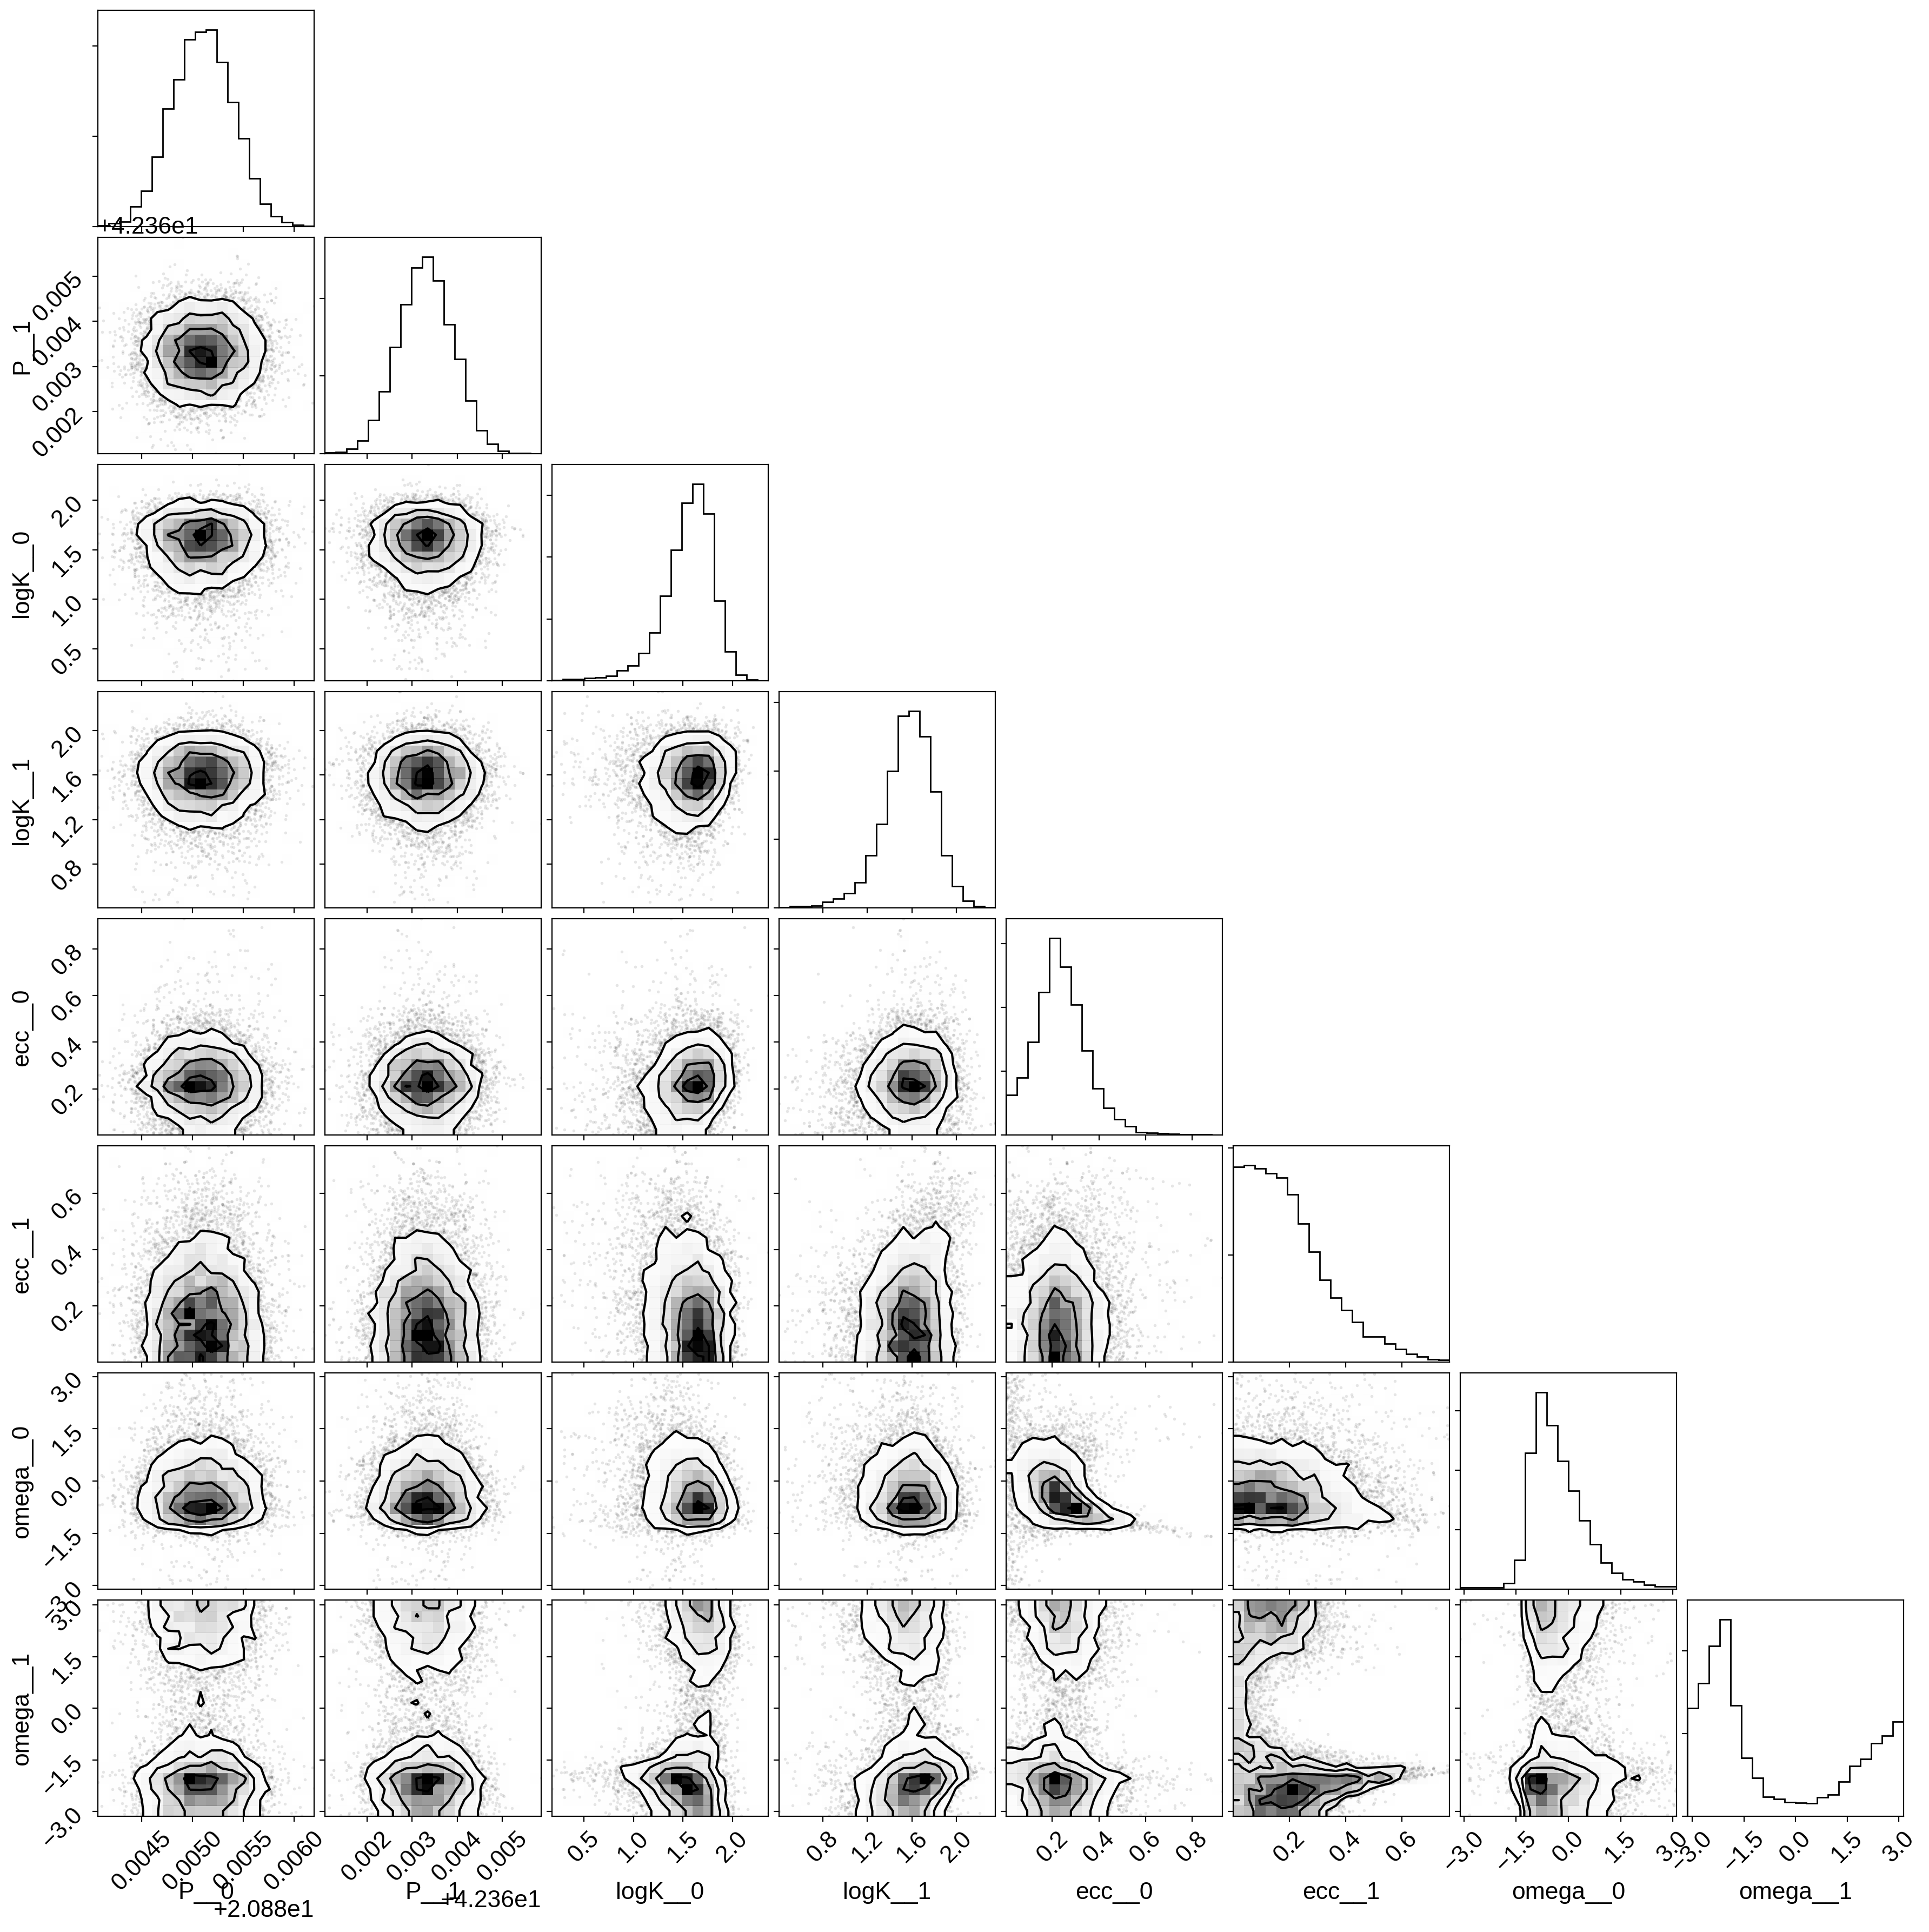

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

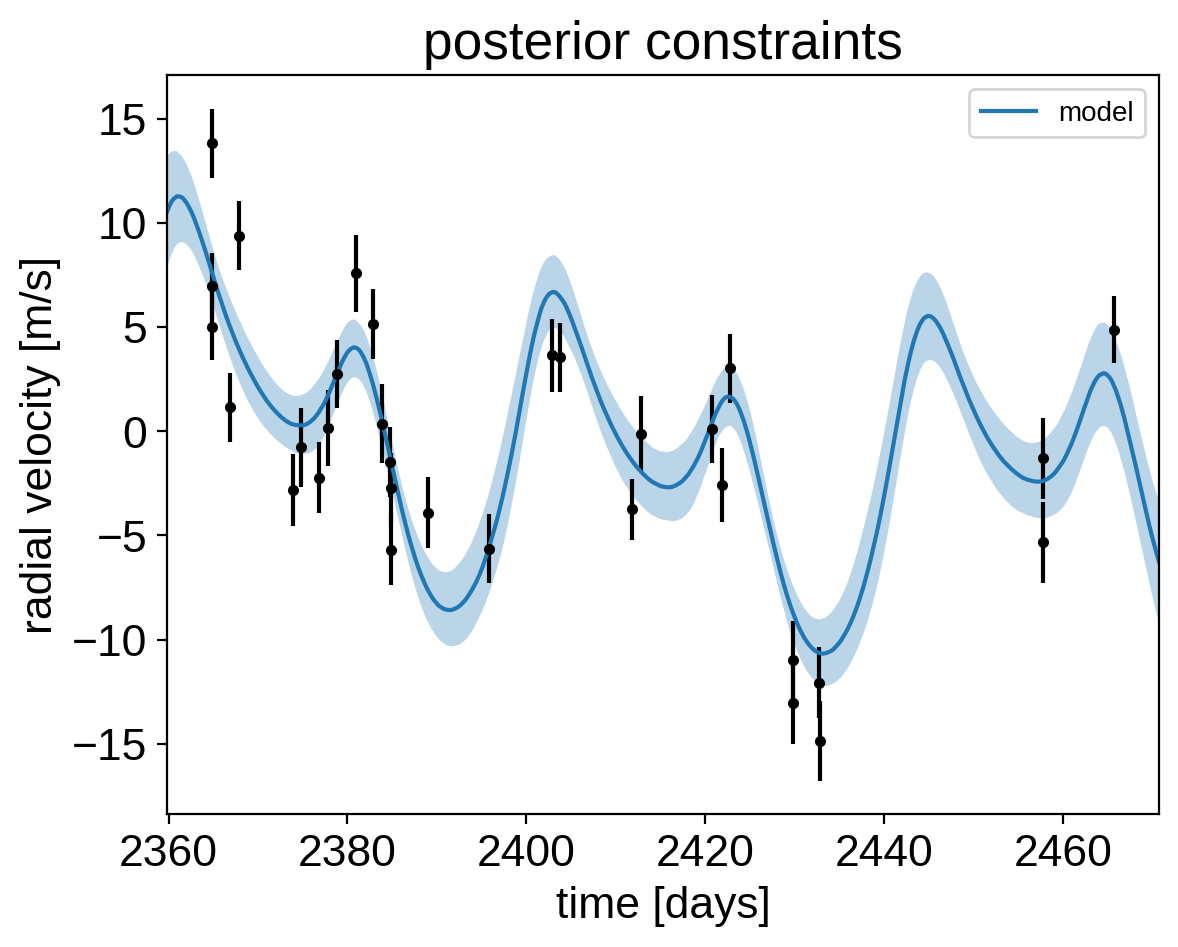

In [12]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

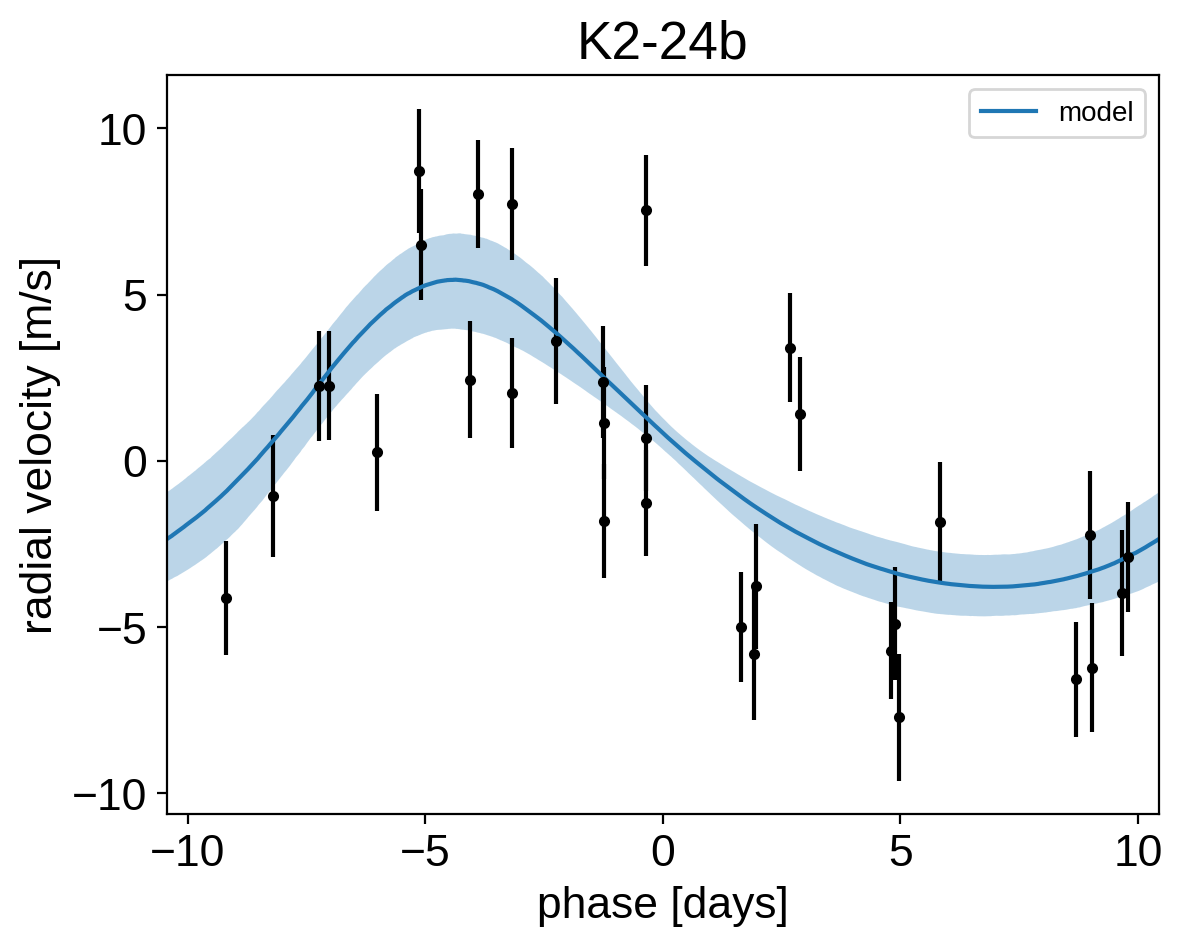

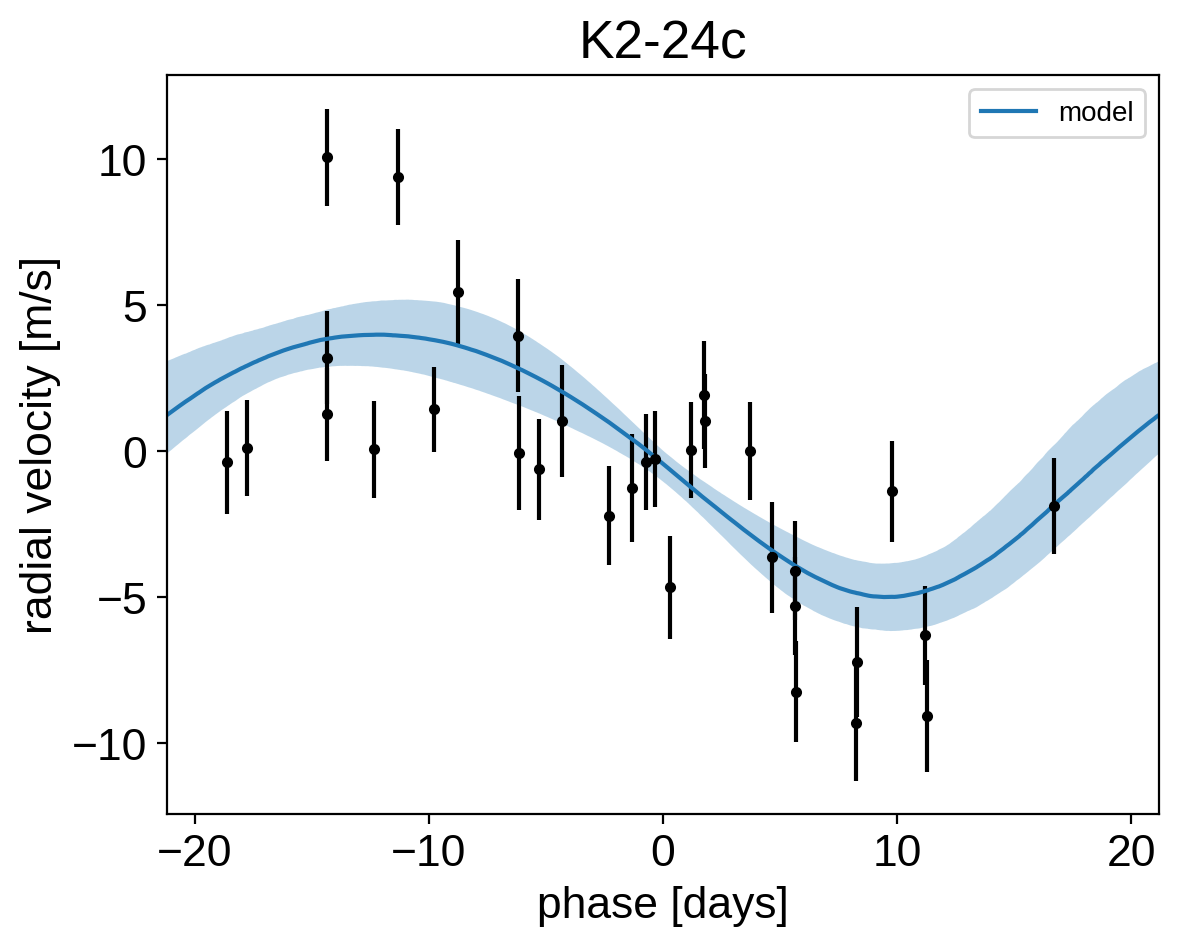

In [13]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [15]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.5},
   month = mar,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
